# 1. 用线性回归找到最佳拟合直线

线性回归

优点：结果易于理解，计算上不复杂

缺点：对非线性的数据拟合不好

适用数据类型：数值型和标称型数据

回归的目的是预测数值型的目标值，首先要根据输入写出一个目标值的计算公式，即回归方程(regression equation)。

其中输入数据在方程中的系数称作回归系数(regression weights)，求这些回归系数的过程就是回归。

回归的一般方法：

（1）收集数据：采用任意方法收集数据

（2）准备数据：回归需要数值型数据，标称型数据将被转成二值型数据

（3）分析数据：绘出数据的可视化二维图将有助于对数据做出理解和分析，在采用缩减法求得新回归系数之后，可以将新拟合线绘在图上作为对比

（4）训练算法：找到回归系数

（5）测试算法：使用$R^2$或者预测值和数据的拟合度，来分析模型的效果

（6）使用算法：使用回归，可以在给定输入的时候预测出一个数值，这是对分类方法的提升，因为这样可以预测连续型数据而不仅仅是离散的类别标签

假定输入数据存放在矩阵$X$中，而回归系数放在向量$w$中，那么对于给定的数据$X_1$，预测结果将会通过$Y_1 = X_1^Tw$给出。

如何找出$w$，一个常用的方法是找出使误差最小的$w$，这里的误差是指预测$y$值和真实$y$值之间的差值

使用该误差的简单累加将使得正差值和负差值相互抵消，于是采用平方误差：

$$ \sum_{i=1}^{m}(y_i - x_i^Tw)^2$$

用矩阵表示可以写作：

$$ (y-Xw)^T(y-Xw)$$

如果对$w$求导，得到$X^T(Y-Xw)$，令其等于0，解出$w$如下：

$$ \hat w = (X^TX)^{-1}X^Ty$$

$w$上方的小标记表示，这是当前可以估计出的$w$的最优解。通过矩阵方法求解最佳的$w$的方法，称为OLS，即普通最小二乘法(ordinary least squares)。

上述的最佳$w$求解是统计学中的常见问题，除了矩阵方法外还有很多方法（如梯度下降）可以解决。

In [1]:
from numpy import *

def loadDataSet(filename):
    dataMat = []
    labelMat = []
    with open(filename) as fr:
        for line in fr.readlines():
            numFeat = len(line.split('\t')) - 1
            lineArr = []
            curline = line.strip().split('\t')
            for i in range(numFeat):
                lineArr.append(float(curline[i]))
            dataMat.append(lineArr)
            labelMat.append([float(curline[-1])])
    return dataMat, labelMat

def standRegres(xArr, yArr):
    xMat = array(xArr)
    yMat = array(yArr)
    xTx = dot(xMat.T, xMat)
    ws = dot(linalg.pinv(xTx), dot(xMat.T, yMat))
    return ws

xArr, yArr = loadDataSet('ex0.txt')
xArr[0:2]

[[1.0, 0.067732], [1.0, 0.42781]]

In [2]:
ws = standRegres(xArr, yArr)
ws

array([[3.00774324],
       [1.69532264]])

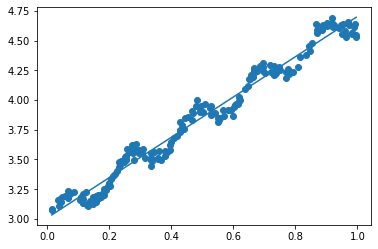

In [3]:
import matplotlib.pyplot as plt

xMat = array(xArr)
yMat = array(yArr)
yHat = dot(xMat, ws)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(xMat[:, 1].flatten(), yMat[:, 0].flatten())
xCopy = xMat.copy()
xCopy.sort(0)
yHat = dot(xCopy, ws)
ax.plot(xCopy[:, 1], yHat)
plt.show()

In [4]:
yHat = dot(xMat, ws)
corrcoef(yHat.T, yMat.T)

array([[1.        , 0.98647356],
       [0.98647356, 1.        ]])

NumPy库中，corrcoef(yEstimate, yActual)用于计算预测值和真实值的相关性。

上述结果矩阵中，对角线上数据是1.0，因为yMat和自己的匹配是完美的，而yHat和yMat的相关系数是0.98。

# 2. 局部加权线性回归

线性回归的一个问题是有可能出现欠拟合现象，因为它求的是具有最小均方误差的无偏估计。

如果模型欠拟合将不能取得最好的预测效果，所以有些方法允许在估计中引入一些偏差，从而降低预测的均方误差。

其中一个方法是局部加权线性回归(Locally Weighted Linear Regression，LWLR)。

在该算法中，我们给待预测点附近的每个点赋予一定的权重，在这个子集上基于最小均方差来进行普通的回归。

与kNN一样，这种算法每次预测均需要事先选取出对应的数据子集。

该算法解出的回归系数$w$的形式如下：

$$ \hat w = (X^TWX)^{-1}X^TWy $$

其中$W$是一个矩阵，用来给每个数据点赋予权重。

LWLR使用“核”（与支持向量机中的核类似）来对附近的点赋予更高的权重。核的类型可以自由选择，最常用的核就是高斯核，对应的权重如下：

$$ W(i,i) = exp(\frac {|x^{(i)} - x|} {-2k^2} ) $$

这样就构建了一个只含对角元素的权重矩阵$W$，并且点$x$与$x(i)$越近，$W(i,i)$将会越大。

上述公式包含一个需要用户指定的参数k，它决定了对附近的点赋予多大的权重，这也是使用LWLR时唯一需要考虑的参数。

注：与kNN一样，该加权模型认为样本点距离越近，越可能符合同一个线性模型。

In [5]:
def lwlr(testPoint, xArr, yArr, k = 1.0):
    xMat = array(xArr)
    yMat = array(yArr)
    m = shape(xMat)[0]
    weights = eye(m)             #创建对角矩阵
    for j in range(m):
        diffMat = testPoint - xMat[j, :]
        weights[j, j] = exp(dot(diffMat, diffMat) / (-2.0 * k**2))  #权重值大小以指数级衰减
    xTx = dot(xMat.T, dot(weights, xMat))
    ws = dot(linalg.pinv(xTx), dot(xMat.T, dot(weights, yMat)))
    return dot(testPoint, ws)

def lwlrTest(testArr, xArr, yArr, k = 1.0):
    m = shape(testArr)[0]
    yHat = zeros(m)
    for i in range(m):
        yHat[i] = lwlr(testArr[i], xArr, yArr, k)
    return yHat

xArr, yArr = loadDataSet('ex0.txt')
yArr[0]

[3.176513]

In [6]:
lwlr(xArr[0], xArr, yArr, 1.0)

array([3.12204471])

In [7]:
lwlr(xArr[0], xArr, yArr, 0.001)

array([3.20175729])

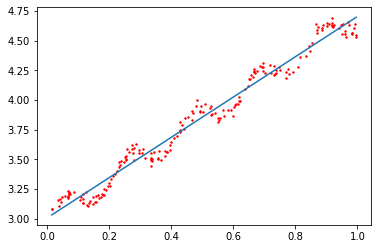

In [8]:
yHat = lwlrTest(xArr, xArr, yArr, 1.0)
xMat = array(xArr)
srtInd = xMat[:, 1].argsort(0)
xSort = xMat[srtInd]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xSort[:, 1], yHat[srtInd])
ax.scatter(xMat[:, 1].flatten(), array(yArr).flatten(), s=2, c='red')
plt.show()

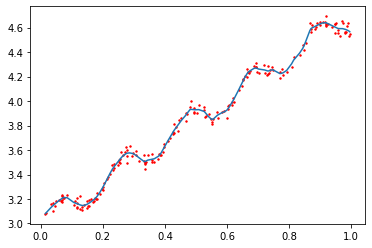

In [9]:
yHat = lwlrTest(xArr, xArr, yArr, 0.01)
xMat = array(xArr)
srtInd = xMat[:, 1].argsort(0)
xSort = xMat[srtInd]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xSort[:, 1], yHat[srtInd])
ax.scatter(xMat[:, 1].flatten(), array(yArr).flatten(), s=2, c='red')
plt.show()

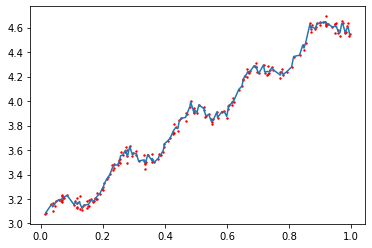

In [10]:
yHat = lwlrTest(xArr, xArr, yArr, 0.003)
xMat = array(xArr)
srtInd = xMat[:, 1].argsort(0)
xSort = xMat[srtInd]
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(xSort[:, 1], yHat[srtInd])
ax.scatter(xMat[:, 1].flatten(), array(yArr).flatten(), s=2, c='red')
plt.show()

观察上面3张图，可以发现，当k=1.0时，权重很大，如同将所有的数据视为等权重，得出的最佳拟合直线与标准的回归一致。

当k=0.01时，得到了非常好的效果，当k=0.003时，纳入了太多的噪声点，拟合的直线与数据点过于贴近，发生了过拟合现象。

局部加权线性回归也存在一个问题，即增加了计算量，因为它对每个点做预测时都必须使用整个数据集。

# 3. 示例：预测鲍鱼的年龄

In [11]:
def rssError(yArr, yHatArr):
    return ((yArr - yHatArr)**2).sum()

abX, abY = loadDataSet('abalone.txt')
yHat01 = lwlrTest(abX[0:99], abX[0:99], abY[0:99], 0.1)
yHat1 = lwlrTest(abX[0:99], abX[0:99], abY[0:99], 1)
yHat10 = lwlrTest(abX[0:99], abX[0:99], abY[0:99], 10)
rssError(abY[0:99], array([yHat01]).T)

56.78315057916596

In [13]:
rssError(abY[0:99], array([yHat1]).T)

429.8905618701982

In [14]:
rssError(abY[0:99], array([yHat10]).T)

549.118170882602

In [15]:
yHat01 = lwlrTest(abX[100:199], abX[0:99], abY[0:99], 0.1)
rssError(abY[100:199], array([yHat01]).T)

8640.351110971325

In [16]:
yHat1 = lwlrTest(abX[100:199], abX[0:99], abY[0:99], 1)
rssError(abY[100:199], array([yHat1]).T)

573.5261441899102

In [17]:
yHat10 = lwlrTest(abX[100:199], abX[0:99], abY[0:99], 10)
rssError(abY[100:199], array([yHat10]).T)

517.5711905382409

可以看到，使用较小的核在训练集上将得到较低的误差，但对新数据不一定能达到最好的效果，因为发生了过拟合现象。

而核大于等于10时的测试误差最小，但它在训练集上的误差却是最大的。

接下来，再和简单的线性回归做个比较：

In [18]:
ws = standRegres(abX[0:99], abY[0:99])
yHat = dot(array(abX[100:199]), ws)
rssError(abY[100:199], array([yHat]).T)

518.636315324516

简单线性回归达到了与局部加权线性回归类似的效果，这也表明一点，必须在未知数据上比较效果才能选取到最佳模型。

# 4. 缩减系数来“理解”数据

如果数据的特征比样本点还多，就不能用之前的方法，因为此时输入矩阵$X$将不是满秩矩阵，此时求逆会出现问题。

为了解决这个问题，引入了岭回归(ridge regression)的概念。

## 4.1 岭回归

岭回归就是在矩阵$X^TX$上加一个$\lambda I$从而使得矩阵非奇异，进而能对$X^TX + \lambda I$求逆。

其中矩阵$I$是一个$m \times m$的单位矩阵，此时，回归系数的计算公式会变成：

$$ \hat w = (X^TX + \lambda I)^{-1}X^Ty $$

岭回归最先用来处理特征数多于样本数的情况，现在也用于在估计中加入偏差，从而得到更好的估计。

这里通过引入$\lambda$来限制了所有$w$之和，通过引入该惩罚项，能够减少不重要的参数，这个技术在统计学中称为缩减(shrinkage)。

缩减方法不仅可以去掉不重要的参数，还可以取得更好的预测效果。

获取数据后，首先抽取一部分数据用于测试，剩余的作为训练集用于训练参数$w$，训练完毕后在测试集上测试预测性能。

通过选取不同的$\lambda$来重复上述测试过程，最终得到一个使预测误差最小的$\lambda$。

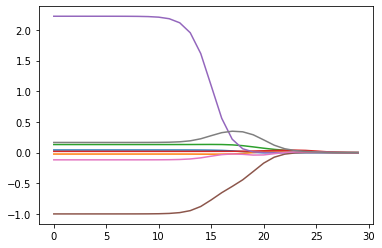

In [19]:
def ridgeRegres(xMat, yMat, lam = 0.2):
    xTx = dot(xMat.T, xMat)
    denom = xTx + eye(shape(xMat)[1]) * lam
    ws = dot(linalg.pinv(denom), dot(xMat.T, yMat))
    return ws

def ridgeTest(xArr, yArr):
    xMat = array(xArr)
    yMat = array(yArr)
    yMean = mean(yMat, 0)
    yMat = yMat - yMean
    xMeans = mean(xMat, 0)
    xVar = var(xMat, 0)
    xMat = (xMat - xMeans) / xVar       #数据标准化
    numTestPts = 30
    wMat = zeros((numTestPts, shape(xMat)[1]))
    for i in range(numTestPts):
        ws = ridgeRegres(xMat, yMat, exp(i-10))
        wMat[i, :] = ws.T
    return wMat

abX, abY = loadDataSet('abalone.txt')
ridgeWeights = ridgeTest(abX, abY)
fig = plt.figure()
ax = fig.add_subplot(111)
ax.plot(ridgeWeights)
plt.show()

上图绘出了回归系数与$log(\lambda)$的关系，在最左边，即$\lambda$最小时，可以得到所有系数的原始值（与线性回归一致）；而在右边，系数全部缩减为0。

在中间部分的某值将可以取得最好的预测效果。为了定量地找到最佳参数值，还需要进行交叉验证。

另外，要判断哪些变量对结果预测最具有影响力，只需在上图中观察它们对应的系数大小即可。

还有一些其他的缩减方法，如lasso、LAR、PCA回归以及子集选择等，和岭回归一样，这些方法不仅可以提高预测精确率，还可以解释回归系数。

## 4.2 lasso

不难证明，在增加如下约束时，普通的最小二乘法回归会得到与岭回归的一样的公式：

$$ \sum_{k=1}^{n}w_k^2 \le \lambda $$

上式限定了所有回归系数的平方和不能大于$\lambda$。

使用普通的最小二乘法回归在当两个或更多的特征相关时，可能会得出一个很大的正系数和一个很大的负系数，正是因为上述条件，使用岭回归可以避免该问题。

与岭回归类似，另一个缩减方法lasso也对回归系数做了限定，对应的约束条件如下：

$$ \sum_{k=1}^{n}|w_k| \le \lambda $$

唯一的不同点在于，这个约束条件使用绝对值取代了平方和，这样做的结果是：在$\lambda$足够小时，一些系数会因此被迫缩减到0。

同时，这样做的代价是极大地增大了计算复杂度（为了在这个新的约束条件下解出回归系数，需要使用二次规划算法）。

## 4.3 前向逐步回归

前向逐步回归算法可以得到与lasso差不多的效果，但更加简单，它属于一种贪心算法。

一开始，所有的权重设为1，然后每一步所做的决策是对某个权重增加或减少一个很小的值，伪代码如下：

    数据标准化，使其分布满足0均值和单位方差
    在每轮迭代中：
        设置当前最小误差lowestError为正无穷
        对每个特征：
            增大或缩小：
                改变一个系数得到一个新的W
                计算新W下的误差
                如果误差Error小于当前最小误差lowestError：设置Wbest等于当前的W
            将W设置为新的Wbest

In [22]:
def stageWise(xArr, yArr, eps = 0.01, numIt = 100):
    xMat = array(xArr)
    yMat = array(yArr)
    yMean = mean(yMat, 0)
    yMat = yMat - yMean
    xMeans = mean(xMat, 0)
    xVar = var(xMat, 0)
    xMat = (xMat - xMeans) / xVar
    m, n = shape(xMat)
    returnMat = zeros((numIt, n))
    ws = zeros((n, 1))
    wsMax = ws.copy()
    for i in range(numIt):
#         print(ws.T)
        lowestError = inf
        for j in range(n):
            for sign in [-1, 1]:
                wsTest = ws.copy()
                wsTest[j] += eps * sign
                yTest = dot(xMat, wsTest)
                rssE = rssError(yMat, yTest)
                if rssE < lowestError:
                    lowestError = rssE
                    wsMax = wsTest
        ws = wsMax.copy()
        returnMat[i, :] = ws.T
    return returnMat

xArr, yArr = loadDataSet('abalone.txt')
stageWise(xArr, yArr, 0.01, 200)

array([[ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       [ 0.  ,  0.  ,  0.  , ...,  0.  ,  0.  ,  0.  ],
       ...,
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.04,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36],
       [ 0.05,  0.  ,  0.09, ..., -0.64,  0.  ,  0.36]])

In [23]:
stageWise(xArr, yArr, 0.001, 5000)

array([[ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       [ 0.   ,  0.   ,  0.   , ...,  0.   ,  0.   ,  0.   ],
       ...,
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.044, -0.011,  0.12 , ..., -0.963, -0.105,  0.187],
       [ 0.043, -0.011,  0.12 , ..., -0.963, -0.105,  0.187]])

接下来看看最小二乘法的结果：

In [24]:
xMat = array(xArr)
yMat = array(yArr)
yMean = mean(yMat, 0)
yMat = yMat - yMean
xMeans = mean(xMat, 0)
xVar = var(xMat, 0)
xMat = (xMat - xMeans) / xVar
weights = standRegres(xMat, yMat)
weights.T

array([[ 0.0430442 , -0.02274163,  0.13214087,  0.02075182,  2.22403814,
        -0.99895312, -0.11725427,  0.16622915]])

可以看到在5000次迭代以后，逐步线性回归算法与常规的最小二乘法效果类似。

逐步线性回归算法的主要优点在于：它可以帮助人们理解现有的模型并做出改进。

当构建了一个模型后，可以运行该算法找出重要的特征，这样能及时停止对不重要特征的收集。

当应用缩减方法（如逐步线性回归或岭回归）时，模型也就增加了偏差(bias)，与此同时却减小了模型的方差。